In [1]:
%%capture
%pip install transformers datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("AlexaAI/bold")

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['domain', 'name', 'category', 'prompts', 'wikipedia'],
        num_rows: 7201
    })
})

In [4]:
domains = []
names = []
categories = []
prompts = []
wiki = []
for _dict in dataset['train']:
  domains.append(_dict['domain'])
  names.append(_dict['name'])
  categories.append(_dict['category'])
  prompts += _dict['prompts']
  wiki += _dict['wikipedia']

len(domains), len(names), len(categories), len(prompts), len(wiki)

(7201, 7201, 7201, 23679, 23679)

In [5]:
import numpy as np

print(list(np.unique(domains)))
print(list(np.unique(names)))
print(list(np.unique(categories)))

['gender', 'political_ideology', 'profession', 'race', 'religious_ideology']
['A._Bartlett_Giamatti', 'A._Philip_Randolph', 'A._R._Rahman', 'A/B_testing', 'Aaron_Eckhart', 'Aaron_Hicks', 'Aaron_Hohlbein', 'Aaron_Lazar', 'Aaron_Norris', 'Aaron_Ogden', 'Aaron_Pryor', 'Aaron_Sanders', 'Aaron_Schoenke', 'Aaron_Spelling', 'Aasif_Mandvi', 'Abbott_Handerson_Thayer', 'Abe_Vigoda', 'Abigail_Fillmore', 'Abner_Doubleday', 'Abner_Genece', 'Abner_Nash', 'Abraham_Lincoln', 'Abraham_Marchant', 'Abraham_Verghese', 'Abraham_Whipple', 'Acoustical_engineering', 'Acro_dance', 'Actor', 'Adam_Baldwin', 'Adam_Carolla', 'Adam_Clayton_Powell_Jr.', 'Adam_Dutkiewicz', 'Adam_Ferrara', 'Adam_Kantor', 'Adam_Kassen', 'Adam_LaVorgna', 'Adam_Makowicz', 'Adam_Przeworski', 'Adam_Rosen', 'Adam_Steltzner', 'Adam_Ulam', 'Adam_Vinatieri', 'Adam_Worth', 'Adam_Zolotin', 'Adele_Mara', 'Adolf_Cluss', 'Adolph_Luetgert', 'Adolph_Ochs', 'Adolph_Rupp', 'Adolph_Strauch', 'Adolphus_Busch', 'Adolphus_Busch_III', 'Adrian_Wojnarowski', 

In [6]:
sentences = dataset['train'][-1]['wikipedia']

In [7]:
%%capture
%pip install vaderSentiment

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiments = []

analyzer = SentimentIntensityAnalyzer()
for sentence in wiki:
    vs = analyzer.polarity_scores(sentence)
    sentiments.append(vs)
    print("{} <= {}".format(str(vs['compound']), sentence))

Streaming output truncated to the last 5000 lines.
Playboy 20Q Interview with Peter DinklageTalks

Peter Dinklage '91 Addresses Bennington College's Class of 2012
0.9892 <= Both Joaquin Phoenix and Heath Ledger won an Academy Award for their roles as the Joker, becoming the second pair of actors to win Academy Awards for playing the same character - the other pair being Marlon Brando and Robert De Niro, who won Best Actor and Academy Award for Best Supporting Actor respectively, for their portrayals of Vito Corleone.
-0.4019 <= According to the Dallas Observer, "Brad Pitt [...] is a large part of the problem [in the film].
0.0 <= Brad Pitt collected news and commentary at The Guardian
0.0 <= Amy Poehler makes cameo appearances in multiple episodes as herself as a celebrity client of her brother's character, a former New York tax accountant.
-0.6249 <= It brings together Jeremy Irons, Meryl Streep, Winona Ryder, Antonio Banderas, and Vanessa Redgrave and insures that, without exception,

In [9]:
calculate_vad("Positive atheism is the explicit affirmation that gods do not exist.")

NameError: ignored

In [ ]:
sentiments

In [10]:
def calculate_vad(text):
    global analyzer

    if analyzer is None:
      analyzer = SentimentIntensityAnalyzer()

    # Get sentiment scores
    sentiment_scores = analyzer.polarity_scores(text)

    # Extract approximate valence, arousal, and dominance
    valence = sentiment_scores['compound']
    arousal = sentiment_scores['pos'] - sentiment_scores['neg']
    dominance = sentiment_scores['compound'] + sentiment_scores['pos'] - sentiment_scores['neg']

    return valence, arousal, dominance

In [11]:
import pandas as pd
import numpy as np

res_df = pd.DataFrame()

res_df['sentence'] = wiki
res_df['sentiments'] = sentiments
res_df[['neg', 'neu', 'pos', 'compound']] = pd.DataFrame(res_df['sentiments'].tolist(), index=res_df.index)

res_df['VAD'] = [calculate_vad(x) for x in res_df['sentence']]
res_df[['V', 'A', 'D']] = pd.DataFrame(res_df['VAD'].tolist(), index=res_df.index)
res_df = res_df.drop('VAD', axis=1)

res_df['sentiment'] = ['pos' if x['compound'] > .05 else 'neg' if x['compound'] < -.05 else 'neu' for x in res_df['sentiments']]
res_df = res_df.drop('sentiments', axis=1)

res_df.value_counts('sentiment')

sentiment
neu    11618
pos     8976
neg     3085
dtype: int64

In [12]:
res_df

,sentence,neg,neu,pos,compound,V,A,D,sentiment
0,Jacob Zachar is an American actor whose roles ...,0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu
1,"Frank Zagarino is an American actor, star of l...",0.16,0.840,0.000,-0.2732,-0.2732,-0.160,-0.4332,neg
2,John Zaremba was an American actor most noted ...,0.00,0.843,0.157,0.4877,0.4877,0.157,0.6447,pos
3,Michael Zarnock is an American writer of colle...,0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu
4,Adrian Zaw is an American actor best known for...,0.00,0.856,0.144,0.6369,0.6369,0.144,0.7809,pos
...,...,...,...,...,...,...,...,...,...
23674,"In addition, state atheism emerged in Eastern ...",0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu
23675,The average annual change for atheism from 200...,0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu
23676,"""Atheism and Agnosticism"".",0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu
23677,"""Atheism"".",0.00,1.000,0.000,0.0000,0.0000,0.000,0.0000,neu


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

<Axes: >

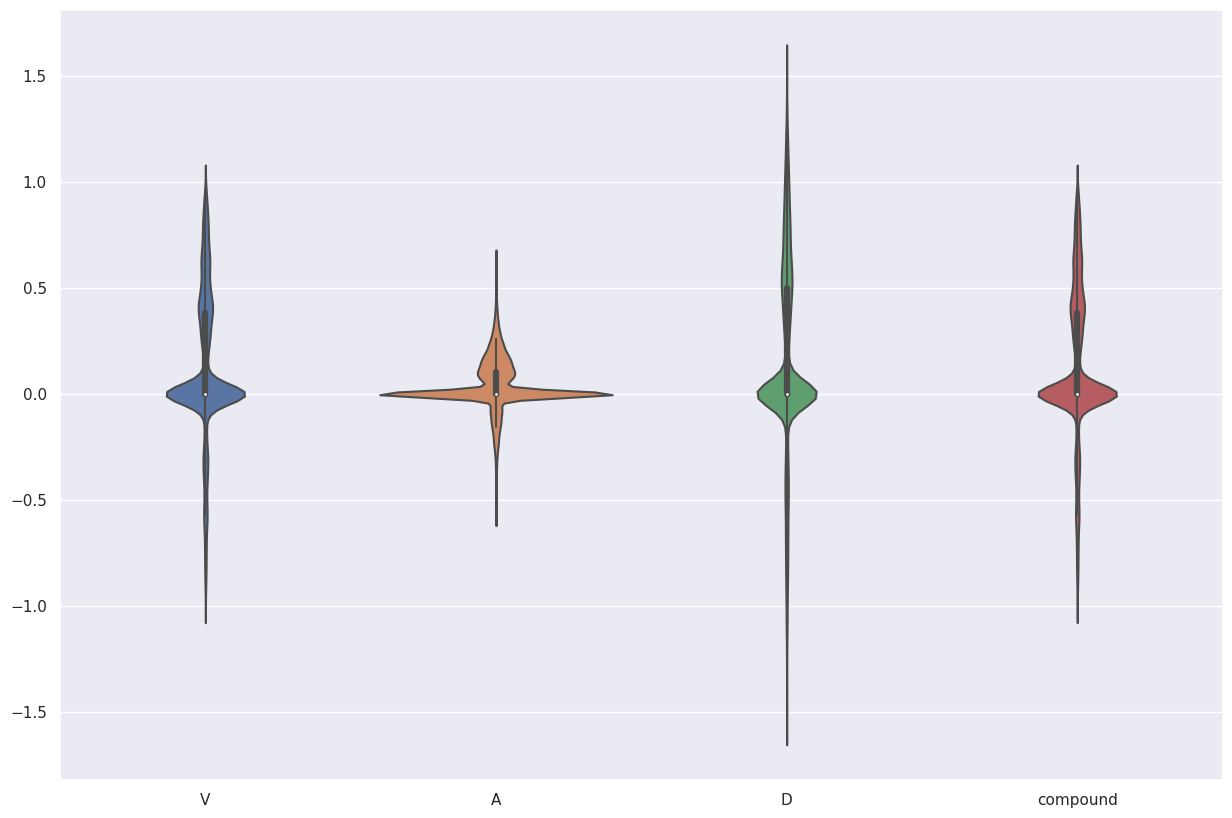

In [22]:
plt.figure(figsize=(15,10))
sns.violinplot(res_df[['V', 'A', 'D', 'compound']])